In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
from scipy import interpolate
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

In [5]:
Iso_T3 = pd.read_csv("M16M2-MH3.csv")
Iso_T10 = pd.read_csv("M16M3-MH10.csv")
ChiT = pd.read_csv("ChiT.dat",sep=' ')

In [7]:
Massa_Molar= 780.26 # g/mol
N_A = 6.022*10**(23) #mol-1
mu_B = 9.274*10**(-21) #erg/G
k_B = 1.380649*10**(-16) #erg/K

In [9]:
Iso_T3['M (mu_B N_A)'] = Iso_T3['M (emu/g)']*(Massa_Molar/(N_A*mu_B))
Iso_T10['M (mu_B N_A)'] = Iso_T10['M (emu/g)']*(Massa_Molar/(N_A*mu_B))
ChiT['mu_eff'] = (ChiT['ChiT']**(1/2))*2.828 # Aqui usei a relação direta que Chi T = N_A mu_eff^2 mu_B^2 / 3 k_B

# Plot dos dados

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\55219\AppData\Local\Temp\ipykernel_10732\2631729782.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Magnetization ($N_A\mu_B$)')
C:\Users\55219\AppData\Local\Temp\ipykernel_10732\2631729782.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Magnetization ($N_A\mu_B$)')


ValueError: '' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

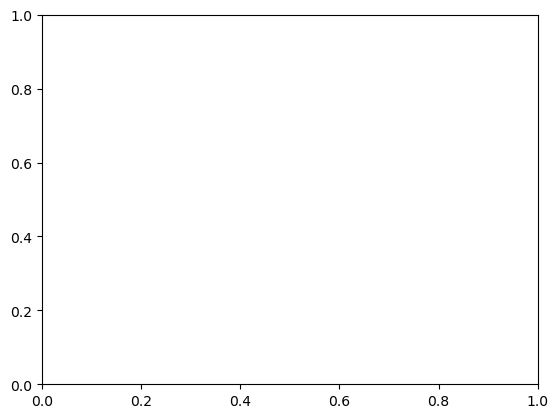

In [12]:
plt.plot(Iso_T3['Magnetic Field (Oe)']/10000,Iso_T3['M (mu_B N_A)'],color='')
plt.plot(Iso_T10['Magnetic Field (Oe)']/10000,Iso_T10['M (mu_B N_A)'],color='')
plt.xlabel('Magnetic Field (T)')
plt.ylabel('Magnetization ($N_A\mu_B$)')
plt.show()

In [ ]:
plt.plot(ChiT['Temperature'],ChiT['mu_eff'])
plt.xlabel('Temperature (K)')
plt.ylabel('$\mu_{eff}$ ($\mu_B$)')
plt.show()

# Fit da magnetização

Conversions:
J = -5.45 cm^-1 = -1.0826e-22 J = -7.841 K
D = 77.0 cm^-1 = 1.5296e-21 J = 110.786 K
E = 25.57 cm^-1 = 5.0793e-22 J = 36.790 K

Using S1 = S2 = 3/2, g = (gx,gy,gz) = (3.3,2.04,2.0), field along z (B = Bz).
Magnetization plotted in units of μB per dimer (i.e. per two-spin unit).



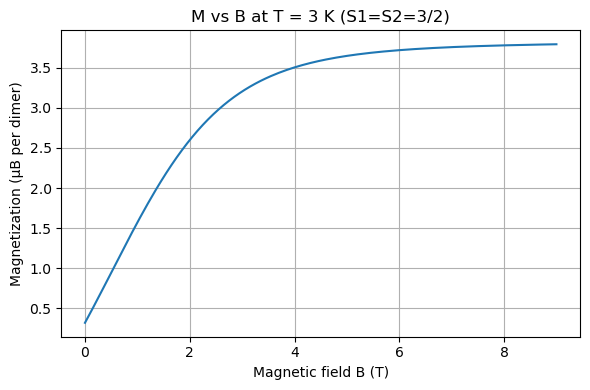


Plot saved to: /mnt/data/magnetization_vs_B_T3K.png


In [16]:
# Plot magnetization vs B (0-9 T) at T=3 K for S1=S2=3/2
# Parameters given by the user:
gx, gy, gz = 3.3, 2.04, 2.0
J_cm = -5.45    # cm-1
D_cm = 77.0     # cm-1
E_cm = 25.57    # cm-1

# Physical constants
import numpy as np
h = 6.62607015e-34      # Planck constant, J s
c = 299792458.0         # speed of light, m/s
kB = 1.380649e-23       # Boltzmann constant, J/K
muB = 9.2740100783e-24  # Bohr magneton, J/T

# conversion from cm^-1 to Joule: E(J) = h*c*(wavenumber in m^-1)
cm_to_J = h * c * 100.0
J_J = J_cm * cm_to_J
D_J = D_cm * cm_to_J
E_J = E_cm * cm_to_J

# Also give conversions to Kelvin (E/kB)
J_K = J_J / kB
D_K = D_J / kB
E_K = E_J / kB

print("Conversions:")
print(f"J = {J_cm} cm^-1 = {J_J:.4e} J = {J_K:.3f} K")
print(f"D = {D_cm} cm^-1 = {D_J:.4e} J = {D_K:.3f} K")
print(f"E = {E_cm} cm^-1 = {E_J:.4e} J = {E_K:.3f} K")
print()
print(f"Using S1 = S2 = 3/2, g = (gx,gy,gz) = ({gx},{gy},{gz}), field along z (B = Bz).")
print("Magnetization plotted in units of μB per dimer (i.e. per two-spin unit).")
print()

# Build spin matrices for arbitrary S
def spin_matrices(S):
    dim = int(2*S+1)
    ms = np.arange(S, -S-1, -1)
    Sz = np.diag(ms)
    Splus = np.zeros((dim, dim), dtype=complex)
    for i, m in enumerate(ms[:-1]):
        j = i+1
        Splus[i,j] = np.sqrt((S - m)*(S + m + 1))
    Sminus = Splus.T
    Sx = 0.5*(Splus + Sminus)
    Sy = -0.5j*(Splus - Sminus)
    return Sx, Sy, Sz

def kron(A, B):
    return np.kron(A, B)

S1 = 1.5; S2 = 1.5
S1x, S1y, S1z = spin_matrices(S1)
S2x, S2y, S2z = spin_matrices(S2)
I1 = np.eye(int(2*S1+1))
I2 = np.eye(int(2*S2+1))

S1x_t = kron(S1x, I2); S1y_t = kron(S1y, I2); S1z_t = kron(S1z, I2)
S2x_t = kron(I1, S2x); S2y_t = kron(I1, S2y); S2z_t = kron(I1, S2z)

# Operators for anisotropy: S1z^2 etc
S1z2_t = kron(np.dot(S1z, S1z), I2)
S1x2_t = kron(np.dot(S1x, S1x), I2)
S1y2_t = kron(np.dot(S1y, S1y), I2)
S1sq_const = S1*(S1+1)*np.eye(int(2*S1+1))
S1sq_t = kron(S1sq_const/3.0, I2)  # the /3 is inside the Hamiltonian form

# Exchange term prefactor uses J in Joules
def build_H(Bz):
    # Exchange (J * S1·S2)
    H_ex = J_J * (np.dot(S1x_t, S2x_t) + np.dot(S1y_t, S2y_t) + np.dot(S1z_t, S2z_t))
    # Single-ion anisotropy (traceless)
    H_D = D_J * (S1z2_t - S1sq_t)
    H_E = E_J * (S1x2_t - S1y2_t)
    # Zeeman (field along z)
    H_Z = - muB * gz * Bz * (S1z_t + S2z_t)  # using gz for both sites
    H = H_ex + H_D + H_E + H_Z
    # Ensure Hermitian
    H = 0.5*(H + H.conj().T)
    return H

# Magnetic moment operator along z: mu_z = muB * gz * (S1z + S2z)
mu_op = muB * gz * (S1z_t + S2z_t)

# Temperature and B range
T = 3.0  # K
B_vals = np.linspace(0.0, 9.0, 181)  # 0 to 9 T, step 0.05 T
M_vals_muB = np.zeros_like(B_vals)

from scipy.linalg import eigh

for i, B in enumerate(B_vals):
    H = build_H(B)
    eigs, vecs = eigh(H)
    # Boltzmann weights (use relative to min energy to avoid underflow)
    beta = 1.0/(kB*T)
    E0 = np.min(eigs)
    weights = np.exp(-beta*(eigs - E0))
    Z = np.sum(weights)
    # expectation values of mu_z in each eigenstate
    mu_diag = np.real_if_close(np.einsum('ij,ji->i', vecs.conj().T @ mu_op, vecs))
    # thermal average of mu_z (in J/T)
    mu_avg = np.sum(mu_diag * weights) / Z
    # convert to μB units (divide by muB) -> μB per dimer
    M_vals_muB[i] = mu_avg / muB

# Save data as table and plot
import pandas as pd
df = pd.DataFrame({'B_T': B_vals, 'M_muB_per_dimer': M_vals_muB})

# Display a small portion of the table
#from caas_jupyter_tools import display_dataframe_to_user
#display_dataframe_to_user("Magnetization data (sample)", df.head(20))

# Plot using matplotlib (single plot, no explicit color set)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(B_vals, M_vals_muB)
plt.xlabel('Magnetic field B (T)')
plt.ylabel('Magnetization (μB per dimer)')
plt.title('M vs B at T = 3 K (S1=S2=3/2)')
plt.grid(True)
plt.tight_layout()
# save figure
fn = '/mnt/data/magnetization_vs_B_T3K.png'
#plt.savefig(fn, dpi=200)
plt.show()

print(f"\nPlot saved to: {fn}")


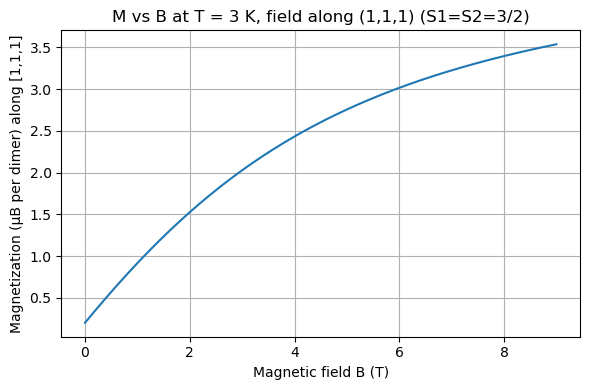

Saved plot to: /mnt/data/magnetization_vs_B_T3K.png


In [18]:
# Compute M vs B for field applied equally in x,y,z (direction [1,1,1]) at T=3K
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

# Parameters (from user)
gx, gy, gz = 3.3, 2.04, 2.0
J_cm = -5.45    # cm-1
D_cm = 77.0     # cm-1
E_cm = 25.57    # cm-1

# Physical constants
h = 6.62607015e-34      # Planck constant, J s
c = 299792458.0         # speed of light, m/s
kB = 1.380649e-23       # Boltzmann constant, J/K
muB = 9.2740100783e-24  # Bohr magneton, J/T

cm_to_J = h * c * 100.0
J_J = J_cm * cm_to_J
D_J = D_cm * cm_to_J
E_J = E_cm * cm_to_J

# Spin matrices
def spin_matrices(S):
    dim = int(2*S+1)
    ms = np.arange(S, -S-1, -1)
    Sz = np.diag(ms)
    Splus = np.zeros((dim, dim), dtype=complex)
    for i, m in enumerate(ms[:-1]):
        j = i+1
        Splus[i,j] = np.sqrt((S - m)*(S + m + 1))
    Sminus = Splus.T
    Sx = 0.5*(Splus + Sminus)
    Sy = -0.5j*(Splus - Sminus)
    return Sx, Sy, Sz

def kron(A,B): return np.kron(A,B)

S1 = 1.5; S2 = 1.5
S1x, S1y, S1z = spin_matrices(S1)
S2x, S2y, S2z = spin_matrices(S2)
I1 = np.eye(int(2*S1+1)); I2 = np.eye(int(2*S2+1))

S1x_t = kron(S1x, I2); S1y_t = kron(S1y, I2); S1z_t = kron(S1z, I2)
S2x_t = kron(I1, S2x); S2y_t = kron(I1, S2y); S2z_t = kron(I1, S2z)

S1z2_t = kron(np.dot(S1z, S1z), I2)
S1x2_t = kron(np.dot(S1x, S1x), I2)
S1y2_t = kron(np.dot(S1y, S1y), I2)
S1sq_const = S1*(S1+1)*np.eye(int(2*S1+1))
S1sq_t = kron(S1sq_const/3.0, I2)

# Magnetic field direction: along (1,1,1)
B_dir = np.array([1.0, 1.0, 1.0])
B_dir = B_dir / np.linalg.norm(B_dir)  # unit vector

# Build H for arbitrary B vector
def build_H_vec(Bvec):
    Bx, By, Bz = Bvec
    H_ex = J_J * (np.dot(S1x_t, S2x_t) + np.dot(S1y_t, S2y_t) + np.dot(S1z_t, S2z_t))
    H_D = D_J * (S1z2_t - S1sq_t)
    H_E = E_J * (S1x2_t - S1y2_t)
    H_Z = - muB * ( gx*Bx*(S1x_t + S2x_t) + gy*By*(S1y_t + S2y_t) + gz*Bz*(S1z_t + S2z_t) )
    H = H_ex + H_D + H_E + H_Z
    H = 0.5*(H + H.conj().T)
    return H

# Magnetic moment operators (vector)
mu_x_op = muB * gx * (S1x_t + S2x_t)
mu_y_op = muB * gy * (S1y_t + S2y_t)
mu_z_op = muB * gz * (S1z_t + S2z_t)

# Temperature and B range
T = 10  # K
B_vals = np.linspace(0.0, 9.0, 181)
M_proj_muB = np.zeros_like(B_vals)

beta = 1.0/(kB*T)
for i, B in enumerate(B_vals):
    Bvec = B * B_dir
    H = build_H_vec(Bvec)
    eigs, vecs = eigh(H)
    E0 = np.min(eigs)
    weights = np.exp(-beta*(eigs - E0))
    Z = np.sum(weights)
    # expectation values of mu components
    mu_x_diag = np.real_if_close(np.einsum('ij,ji->i', vecs.conj().T @ mu_x_op, vecs))
    mu_y_diag = np.real_if_close(np.einsum('ij,ji->i', vecs.conj().T @ mu_y_op, vecs))
    mu_z_diag = np.real_if_close(np.einsum('ij,ji->i', vecs.conj().T @ mu_z_op, vecs))
    # projection along B direction
    mu_proj_diag = B_dir[0]*mu_x_diag + B_dir[1]*mu_y_diag + B_dir[2]*mu_z_diag
    mu_avg = np.sum(mu_proj_diag * weights) / Z
    M_proj_muB[i] = mu_avg / muB  # in muB per dimer

# Save and plot
import pandas as pd
df = pd.DataFrame({'B_T': B_vals, 'M_muB_per_dimer_along_111': M_proj_muB})
#from caas_jupyter_tools import display_dataframe_to_user
#display_dataframe_to_user("Magnetization (field along [1,1,1])", df.head(20))

plt.figure(figsize=(6,4))
plt.plot(B_vals, M_proj_muB)
plt.xlabel('Magnetic field B (T)')
plt.ylabel('Magnetization (μB per dimer) along [1,1,1]')
plt.title('M vs B at T = 3 K, field along (1,1,1) (S1=S2=3/2)')
plt.grid(True)
plt.tight_layout()
#fn = '/mnt/data/magnetization_vs_B_T3K_111.png'
#plt.savefig(fn, dpi=200)
plt.show()

print(f"Saved plot to: {fn}")


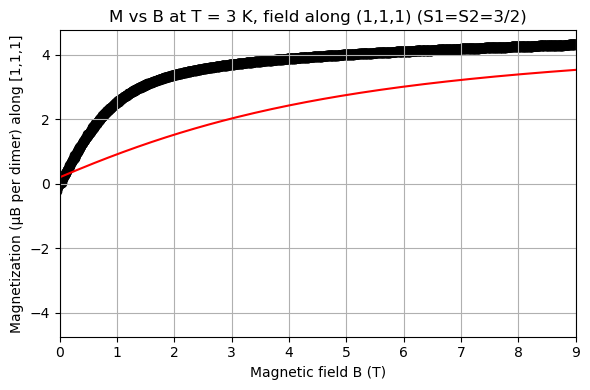

In [20]:
plt.figure(figsize=(6,4))
plt.scatter(Iso_T3['Magnetic Field (Oe)']/10000,Iso_T3['M (mu_B N_A)'],color='black')
plt.plot(B_vals, M_proj_muB,color='red')
plt.xlabel('Magnetic field B (T)')
plt.ylabel('Magnetization (μB per dimer) along [1,1,1]')
plt.title('M vs B at T = 3 K, field along (1,1,1) (S1=S2=3/2)')
plt.xlim(0,9)
plt.grid(True)
plt.tight_layout()
#fn = '/mnt/data/magnetization_vs_B_T3K_111.png'
#plt.savefig(fn, dpi=200)
plt.show()

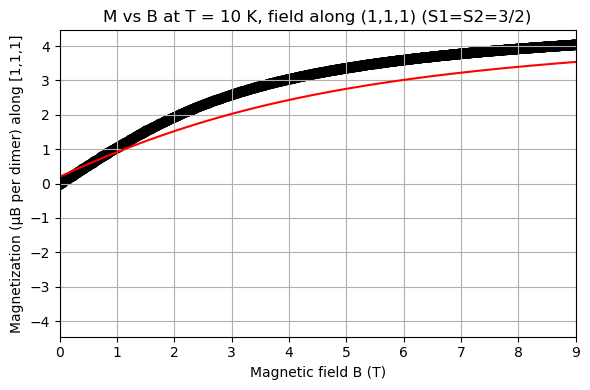

In [22]:
plt.figure(figsize=(6,4))
plt.scatter(Iso_T10['Magnetic Field (Oe)']/10000,Iso_T10['M (mu_B N_A)'],color='black')
plt.plot(B_vals, M_proj_muB,color='red')
plt.xlabel('Magnetic field B (T)')
plt.ylabel('Magnetization (μB per dimer) along [1,1,1]')
plt.title('M vs B at T = 10 K, field along (1,1,1) (S1=S2=3/2)')
plt.grid(True)
plt.xlim(0,9)
plt.tight_layout()
#fn = '/mnt/data/magnetization_vs_B_T3K_111.png'
#plt.savefig(fn, dpi=200)
plt.show()

In [24]:
import numpy as np
from scipy.linalg import eigh
from numpy.polynomial.legendre import leggauss

# função que devolve M(B,T;theta,phi) usando seu build_H e operador mu_proj
def M_for_orientation(B, T, theta, phi):
    # montar Bvec = B * [sinθ cosφ, sinθ sinφ, cosθ]
    Bvec = B * np.array([np.sin(theta)*np.cos(phi),
                         np.sin(theta)*np.sin(phi),
                         np.cos(theta)])
    H = build_H_vec(Bvec)    # sua função que inclui g-rotation/anisotropy
    E, V = eigh(H)
    beta = 1.0/(kB*T)
    E0 = np.min(E)
    weights = np.exp(-beta*(E - E0))
    Z = weights.sum()
    mu_diag = np.real_if_close(np.einsum('ij,ji->i', V.conj().T @ mu_op, V))
    # projecção de mu ao longo de B (unit vector)
    mu_proj = (Bvec/np.linalg.norm(Bvec)).dot([mu_x_diag, mu_y_diag, mu_z_diag]) # ou calcule componentes separadas
    return (mu_proj * weights).sum() / Z

# Gauss-Legendre em x = cosθ
Ntheta, Nphi = 30, 60
x_nodes, x_weights = leggauss(Ntheta)   # nodes in [-1,1], for cosθ
phis = np.linspace(0, 2*np.pi, Nphi, endpoint=False)
dphi = 2*np.pi / Nphi

M_powder = 0.0
for i, x in enumerate(x_nodes):
    theta = np.arccos(x)
    w_theta = x_weights[i]  # peso em x = cosθ
    for phi in phis:
        M_theta_phi = M_for_orientation(B, T, theta, phi)
        M_powder += w_theta * dphi * M_theta_phi

M_powder /= (4*np.pi)  # normalização se necessário (leggauss pesos somam 2)


C:\Users\55219\AppData\Local\Temp\ipykernel_10732\525500493.py:72: RuntimeWarning: invalid value encountered in divide
  Bhat = Bvec/np.linalg.norm(Bvec)


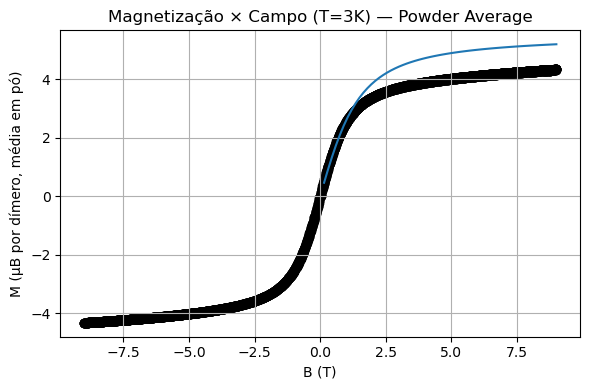

In [30]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss

# Physical constants
h = 6.62607015e-34
c = 299792458.0
kB = 1.380649e-23
muB = 9.2740100783e-24

# Parameters
gx, gy, gz = 2.5,2.5,2.45
J_cm, D_cm, E_cm = -5.95, 62,15.99
cm_to_J = h * c * 100.0
J_J, D_J, E_J = J_cm*cm_to_J, D_cm*cm_to_J, E_cm*cm_to_J

# Spin matrices
def spin_matrices(S):
    dim = int(2*S+1)
    ms = np.arange(S, -S-1, -1)
    Sz = np.diag(ms)
    Splus = np.zeros((dim, dim), dtype=complex)
    for i, m in enumerate(ms[:-1]):
        Splus[i, i+1] = np.sqrt((S-m)*(S+m+1))
    Sminus = Splus.T
    Sx = 0.5*(Splus + Sminus)
    Sy = -0.5j*(Splus - Sminus)
    return Sx, Sy, Sz

def kron(A,B): return np.kron(A,B)

S1=S2=1.5
S1x,S1y,S1z=spin_matrices(S1)
S2x,S2y,S2z=spin_matrices(S2)
I1=np.eye(int(2*S1+1)); I2=np.eye(int(2*S2+1))

S1x_t, S1y_t, S1z_t = kron(S1x,I2), kron(S1y,I2), kron(S1z,I2)
S2x_t, S2y_t, S2z_t = kron(I1,S2x), kron(I1,S2y), kron(I1,S2z)

S1z2_t = kron(S1z@S1z, I2)
S1x2_t = kron(S1x@S1x, I2)
S1y2_t = kron(S1y@S1y, I2)
S1sq_t = kron((S1*(S1+1)/3)*np.eye(int(2*S1+1)), I2)

mu_x_op = muB*gx*(S1x_t+S2x_t)
mu_y_op = muB*gy*(S1y_t+S2y_t)
mu_z_op = muB*gz*(S1z_t+S2z_t)

def build_H(Bvec):
    Bx,By,Bz=Bvec
    H_ex = J_J*(S1x_t@S2x_t + S1y_t@S2y_t + S1z_t@S2z_t)
    H_D = D_J*(S1z2_t - S1sq_t)
    H_E = E_J*(S1x2_t - S1y2_t)
    H_Z = -muB*(gx*Bx*(S1x_t+S2x_t) + gy*By*(S1y_t+S2y_t) + gz*Bz*(S1z_t+S2z_t))
    H = H_ex + H_D + H_E + H_Z
    return 0.5*(H+H.conj().T)

def M_orientation(B, T, theta, phi):
    Bvec = B*np.array([np.sin(theta)*np.cos(phi),
                       np.sin(theta)*np.sin(phi),
                       np.cos(theta)])
    H = build_H(Bvec)
    E, V = eigh(H)
    beta=1/(kB*T)
    E0=np.min(E)
    w=np.exp(-beta*(E-E0))
    Z=w.sum()
    mu_x = np.real(np.einsum('ij,ji->i', V.conj().T@mu_x_op, V))
    mu_y = np.real(np.einsum('ij,ji->i', V.conj().T@mu_y_op, V))
    mu_z = np.real(np.einsum('ij,ji->i', V.conj().T@mu_z_op, V))
    Bhat = Bvec/np.linalg.norm(Bvec)
    mu_proj = Bhat[0]*mu_x + Bhat[1]*mu_y + Bhat[2]*mu_z
    return (mu_proj*w).sum()/Z

# Powder integration
Ntheta, Nphi = 10, 20
x_nodes, x_weights = leggauss(Ntheta)
phis = np.linspace(0, 2*np.pi, Nphi, endpoint=False)
dphi = 2*np.pi/Nphi

def M_powder(B, T):
    acc=0.0
    for xi, wi in zip(x_nodes, x_weights):
        theta=np.arccos(xi)
        for phi in phis:
            acc += wi*dphi * M_orientation(B,T,theta,phi)
    return acc/(4*np.pi)

# Compute curve
T=3.0
Bvals = np.linspace(0,9,61)
Mvals=[]
for B in Bvals:
    Mvals.append(M_powder(B,T)/muB)

# Plot
plt.figure(figsize=(6,4))
plt.scatter(Iso_T3['Magnetic Field (Oe)']/10000,Iso_T3['M (mu_B N_A)'],color='black')
plt.plot(Bvals, Mvals)
#plt.ylim(0,9)
plt.xlabel("B (T)")
plt.ylabel("M (μB por dímero, média em pó)")
plt.title("Magnetização × Campo (T=3K) — Powder Average")
plt.grid(True)
plt.tight_layout()

#fn="/mnt/data/M_vs_B_powder_3K.png"
#plt.savefig(fn, dpi=200)
plt.show()


No exemplo acima faltou colocar o diamagnetismo. Isso pode ajudar a magnetização a descer um pouco e de repente o fit fica melhor.

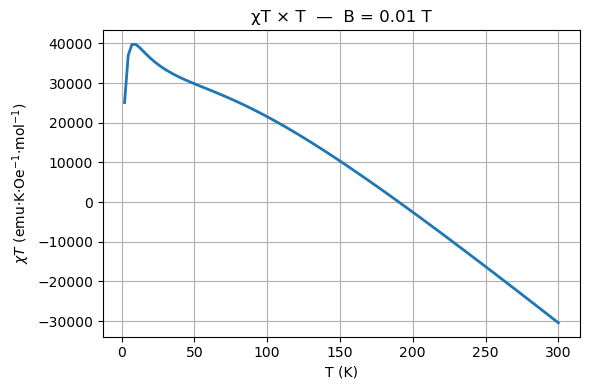

In [29]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

# =========================
# Constantes físicas (SI)
# =========================
NA = 6.02214076e23  # mol^-1
h  = 6.62607015e-34      # J s
c  = 299792458.0        # m/s
kB = 1.380649e-23       # J/K
muB = 9.2740100783e-24  # J/T

cm_to_J = h * c * 100.0  # cm^-1 -> J

# =========================
# Parâmetros do sistema
# =========================
gx, gy, gz = 2.0, 2.1, 3.47
J_cm, D_cm, E_cm = -4.87, 57.22, 6.35

J_J = J_cm * cm_to_J
D_J = D_cm * cm_to_J
E_J = E_cm * cm_to_J

S1 = S2 = 3/2
dim = int((2*S1+1)**2)

# =========================
# Matrizes de spin
# =========================
def spin_matrices(S):
    m = np.arange(S, -S-1, -1)
    dim = len(m)
    Sz = np.diag(m)
    Sp = np.zeros((dim, dim), dtype=complex)
    for i in range(dim-1):
        Sp[i, i+1] = np.sqrt(S*(S+1) - m[i+1]*m[i])
    Sm = Sp.T
    Sx = 0.5*(Sp + Sm)
    Sy = -0.5j*(Sp - Sm)
    return Sx, Sy, Sz

def kron(A, B): 
    return np.kron(A, B)

S1x, S1y, S1z = spin_matrices(S1)
S2x, S2y, S2z = spin_matrices(S2)

I1 = np.eye(int(2*S1+1))
I2 = np.eye(int(2*S2+1))

S1x_t, S1y_t, S1z_t = kron(S1x, I2), kron(S1y, I2), kron(S1z, I2)
S2x_t, S2y_t, S2z_t = kron(I1, S2x), kron(I1, S2y), kron(I1, S2z)

# ZFS – ambos os spins
S1z2_t = kron(S1z@S1z, I2)
S2z2_t = kron(I1, S2z@S2z)
S1x2_t = kron(S1x@S1x, I2)
S2x2_t = kron(I1, S2x@S2x)
S1y2_t = kron(S1y@S1y, I2)
S2y2_t = kron(I1, S2y@S2y)

S1sq_t = kron((S1*(S1+1)/3)*np.eye(int(2*S1+1)), I2)
S2sq_t = kron(I1, (S2*(S2+1)/3)*np.eye(int(2*S2+1)))

# =========================
# Operadores de momento
# =========================
mu_x_op = muB * gx * (S1x_t + S2x_t)
mu_y_op = muB * gy * (S1y_t + S2y_t)
mu_z_op = muB * gz * (S1z_t + S2z_t)

# =========================
# Hamiltoniano
# =========================
def build_H(Bx, By, Bz):
    H_ex = J_J * (
        S1x_t@S2x_t + S1y_t@S2y_t + S1z_t@S2z_t
    )

    H_D = D_J * (
        (S1z2_t - S1sq_t) +
        (S2z2_t - S2sq_t)
    )

    H_E = E_J * (
        (S1x2_t - S1y2_t) +
        (S2x2_t - S2y2_t)
    )

    H_Z = -muB * (
        gx*Bx*(S1x_t + S2x_t) +
        gy*By*(S1y_t + S2y_t) +
        gz*Bz*(S1z_t + S2z_t)
    )

    H = H_ex + H_D + H_E + H_Z
    return 0.5*(H + H.conj().T)

# =========================
# Magnetização para campo em uma direção
# =========================
def magnetization(Bx, By, Bz, T, mu_op):
    H = build_H(Bx, By, Bz)
    E, V = eigh(H)

    beta = 1/(kB*T)
    E0 = E.min()
    w = np.exp(-beta*(E - E0))
    Z = w.sum()

    mu_exp = np.real(np.einsum(
        'ij,ji->i', V.conj().T @ mu_op, V
    ))

    return (mu_exp * w).sum() / Z  # J/T

# =========================
# Susceptibilidades principais
# =========================
def chi_x(T, B):
    return magnetization(B,0,0,T,mu_x_op)/B

def chi_y(T, B):
    return magnetization(0,B,0,T,mu_y_op)/B

def chi_z(T, B):
    return magnetization(0,0,B,T,mu_z_op)/B

def chiT_powder_emu(T, B=0.01):
    chiT_SI = chiT_powder(T, B)   # J K / T^2 por dímero
    return chiT_SI * NA * 1e3     # emu K / Oe mol
# =========================
# χ powder estilo DAVE
# =========================
chi0 = -0.0000000000000000000000005   # diamagnético (SI, por dímero)

def chiT_powder(T, B=0.01):
    chi_avg = (chi_x(T,B) + chi_y(T,B) + chi_z(T,B))/3
    return (chi_avg + chi0) * T

# =========================
# Curva χT × T
# =========================
Tvals = np.linspace(2, 300, 120)
chiT_vals = [chiT_powder_emu(T) for T in Tvals]

plt.figure(figsize=(6,4))
plt.plot(Tvals, chiT_vals, lw=2)
plt.xlabel("T (K)")
plt.ylabel(r"$\chi T$ (emu·K·Oe$^{-1}$·mol$^{-1}$)")
plt.title("χT × T  —  B = 0.01 T")
plt.grid(True)
plt.tight_layout()
plt.show()


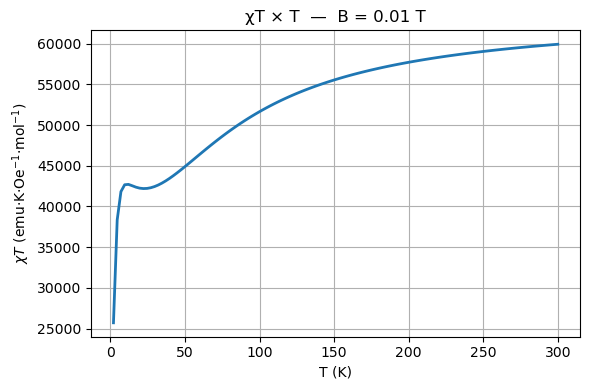

In [7]:
chiT_vals = [chiT_powder_emu(T) for T in Tvals]

plt.figure(figsize=(6,4))
plt.plot(Tvals, chiT_vals, lw=2)
plt.xlabel("T (K)")
plt.ylabel(r"$\chi T$ (emu·K·Oe$^{-1}$·mol$^{-1}$)")
plt.title("χT × T  —  B = 0.01 T")
plt.grid(True)
plt.tight_layout()
plt.show()